# Project 2, Part 1

Ashton Cole

AVC687

COE 379L: Software Design for Responsive Intelligent Systems

## Description

We are interested in using a breast cancer patient dataset to build a model which predicts relapsing based on personal and tumor characteristics.

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
bc = pd.read_csv('bc.csv')

## Exporation

In [3]:
bc.shape

(286, 10)

In [4]:
bc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class        286 non-null    object
 1   age          286 non-null    object
 2   menopause    286 non-null    object
 3   tumor-size   286 non-null    object
 4   inv-nodes    286 non-null    object
 5   node-caps    286 non-null    object
 6   deg-malig    286 non-null    int64 
 7   breast       286 non-null    object
 8   breast-quad  286 non-null    object
 9   irradiat     286 non-null    object
dtypes: int64(1), object(9)
memory usage: 22.5+ KB


Here, we see that there are 10 columns of 286 records. Although there do not seem to be any null entries upon initial inspection, they could be represented with a non-null value.

## Column Inspections

Here we want to inspect the columns, fix null entries, convert their data type appropriately, and drop if the column is irrelevant for analysis. Null entries will ideally be replaced with the median of the field.

### Class

In [5]:
bc['class'].unique()

array(['no-recurrence-events', 'recurrence-events'], dtype=object)

Class essentially refers to whether or not there is a relapse. It is a binary category, making one-hot encoding, i.e. a boolean, appropriate. The conversion from categorical to one-hot encoding will be done in one command at the end.

In [6]:
bc['class'] = bc['class'].astype('category')
bc['class']

0      no-recurrence-events
1      no-recurrence-events
2      no-recurrence-events
3      no-recurrence-events
4      no-recurrence-events
               ...         
281       recurrence-events
282       recurrence-events
283       recurrence-events
284       recurrence-events
285       recurrence-events
Name: class, Length: 286, dtype: category
Categories (2, object): ['no-recurrence-events', 'recurrence-events']

### Age

In [7]:
bc['age'].unique()

array(['30-39', '40-49', '60-69', '50-59', '70-79', '20-29'], dtype=object)

Interestingly, age is not stored as an integer, but as a set of ranges. This means that on one hand, it could be represented categorically. On the other hand, ordinality could be retained by representing the age as the average of each range. For example, all in the range 20-29 could be approximated as 25 years old. Neither solution is perfect. One-hot encoding for this kind of data significantly increases the number of columns and loses ordinality and "distance," while averaging is still not very well-representative either. The second option will be tested for now, and possibly reneged based on the model's performance.

In [8]:
bc['age'] = bc['age'].replace({'20-29': 25,
                               '30-39': 35,
                               '40-49': 45,
                               '50-59': 55,
                               '60-69': 65,
                               '70-79': 75}).astype(int)
bc['age'].unique()

array([35, 45, 65, 55, 75, 25])

### Menopause

In [9]:
bc['menopause'].unique()

array(['premeno', 'ge40', 'lt40'], dtype=object)

Someone can either be premenopausal, "ge40," or "lt40." It is not entirely clear, but the latter two could be abbreviations of "greater than or equal to 40" and "less than 40." This in turn could mean the age of onset of menopause, or just the age of the patient. If it were the latter, this distinction would be redundant, so the variable is compared against age.

In [10]:
bc[bc['menopause'] == 'lt40']['age'].unique()

array([65, 55, 35])

Some people in the "lt40" category are older than 40, so this distinction should be kept, regardless of its precise meaning.

In [11]:
bc['menopause'] = bc['menopause'].astype('category')

### Tumor Size

In [12]:
bc['tumor-size'].unique()

array(['30-34', '20-24', '15-19', '0-4', '25-29', '50-54', '10-14',
       '40-44', '35-39', '5-9', '45-49'], dtype=object)

The same reasoning is used as that for age.

In [13]:
bc['tumor-size'] = bc['tumor-size'].replace({'0-4': 2,
                                             '5-9': 7,
                                             '10-14': 12,
                                             '15-19': 17,
                                             '20-24': 22,
                                             '25-29': 27,
                                             '30-34': 32,
                                             '35-39': 37,
                                             '40-44': 42,
                                             '45-49': 47,
                                             '50-54': 52}).astype(float)
bc['tumor-size'].unique()

array([32., 22., 17.,  2., 27., 52., 12., 42., 37.,  7., 47.])

### Inv Nodes

In [14]:
bc['inv-nodes'].unique()

array(['0-2', '6-8', '9-11', '3-5', '15-17', '12-14', '24-26'],
      dtype=object)

The same reasoning is used as that for age.

In [15]:
bc['inv-nodes'] = bc['inv-nodes'].replace({'0-2': 1,
                                           '3-5': 4,
                                           '6-8': 7,
                                           '9-11': 10,
                                           '12-14': 13,
                                           '15-17': 16,
                                           '18-20': 19,
                                           '21-23': 22,
                                           '24-26': 25})
bc['inv-nodes'].unique()

array([ 1,  7, 10,  4, 16, 13, 25])

### Node Caps

In [16]:
bc['node-caps'].unique()

array(['no', 'yes', '?'], dtype=object)

Here we find a "?" marking null values in a boolean category. There either are or are not node caps. This means that either these entries need to be removed, the column needs to be excluded from analysis, or the category is instead a trinary. Let's inspect how many null entries there are first.

In [17]:
len(bc[bc['node-caps'] == '?'])

8

Since there are only 8 "?," it makes most sense to just remove these values. They arent enough to justify their own category, nor removing the whole column. It is best to just shave off the data set by a few rows.

In [18]:
bc = bc[bc['node-caps'] != '?']
bc['node-caps'] = bc['node-caps'].astype('category')
bc['node-caps'].unique()

['no', 'yes']
Categories (2, object): ['no', 'yes']

### Deg Malig

In [19]:
bc['deg-malig'].unique()

array([3, 2, 1])

This field likely refers to the degree of malignancy of the tumor. Although this is numeric and ordinal, the number represents *qualitative* scale. It does not encode the same sort of "distance" as age, tumor size, or the number of nodes. Thus, this is converted to a category as well.

In [20]:
bc['deg-malig'] = bc['deg-malig'].astype('category')

### Breast

In [21]:
bc['breast'].unique()

array(['left', 'right'], dtype=object)

This likely refers to which breast has the tumor. It is a binary category.

In [22]:
bc['breast'] = bc['breast'].astype('category')

### Breast Quad

In [23]:
bc['breast-quad'].unique()

array(['left_low', 'right_up', 'left_up', 'right_low', 'central', '?'],
      dtype=object)

This likely refers to the region of the breast where the tumor occurs. It is a categorical variable, but again we have to contend with unknown entries.

In [24]:
len(bc[bc['breast-quad'] == '?'])

1

Since there is only one unknown entry, this can be safely excluded from our model without much harm.

In [25]:
bc = bc[bc['breast-quad'] != '?']
bc['breast-quad'] = bc['breast-quad'].astype('category')
bc['breast-quad'].unique()

['left_low', 'right_up', 'left_up', 'right_low', 'central']
Categories (5, object): ['central', 'left_low', 'left_up', 'right_low', 'right_up']

### Irradiat

In [26]:
bc['irradiat'].unique()

array(['no', 'yes'], dtype=object)

This likely refers to whether radiation therapy was performed. It is a binary category.

In [27]:
bc['irradiat'] = bc['irradiat'].astype('category')

## Univariate Analysis

The distributions of each variable are now studied.

### Class

Thankfully, full remission is more common than not, but there are enough recurrence events in the data set to gain insights.

/usr/local/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<Axes: xlabel='class', ylabel='count'>

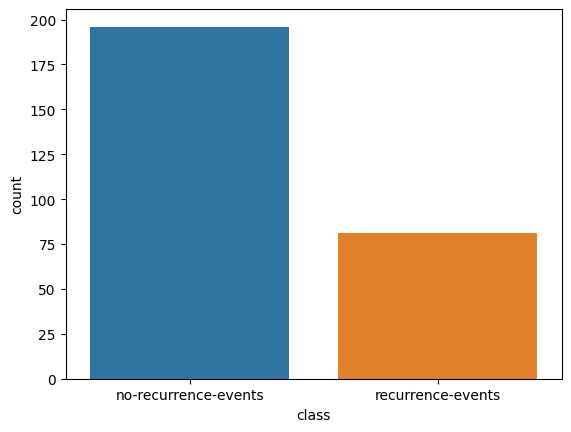

In [28]:
sns.countplot(x=bc['class'])

### Age

Ages show a normal-like distribution, averaged around 50.

/usr/local/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='age', ylabel='Count'>

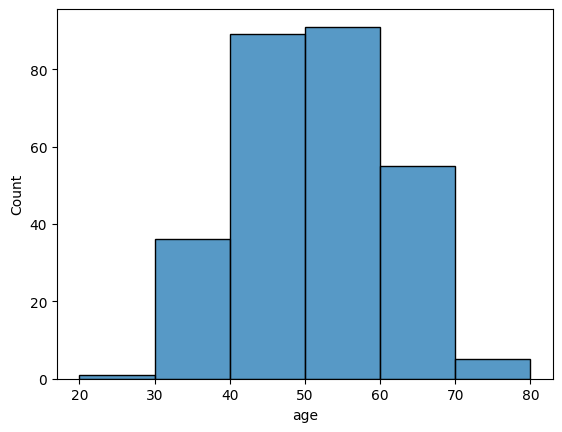

In [29]:
sns.histplot(data=bc['age'], bins=[20, 30, 40, 50, 60, 70, 80])

### Menopause

The "lt40" category is significantly smaller than the other two. It could just be quite rare, which lends credence that it refers to menopause happening before age 40. The problem is that this leaves the model dependent on only a handful of cases for this category. As can be seen below, none of the 5 cases had relapses. Perhaps early menopause decreases the chances, even significantly, but it is hard to be confident with such a small sample size. It would be safer to exclude this category from analysis.

/usr/local/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<Axes: xlabel='menopause', ylabel='count'>

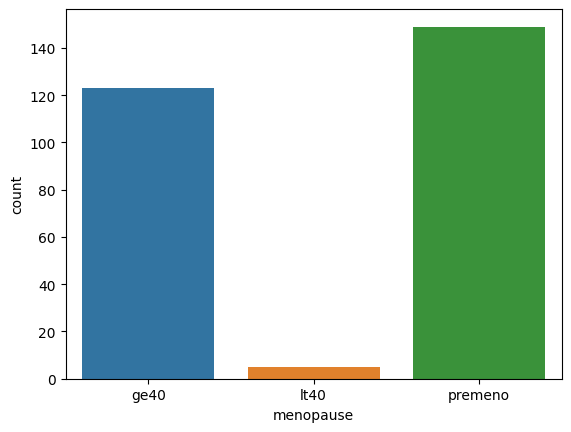

In [30]:
sns.countplot(x=bc['menopause'])

In [31]:
bc[bc['menopause'] == 'lt40']

,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
12,no-recurrence-events,65,lt40,12.0,1,no,1,left,right_up,no
15,no-recurrence-events,65,lt40,32.0,1,no,1,left,left_low,no
50,no-recurrence-events,55,lt40,17.0,1,no,2,left,left_low,no
149,no-recurrence-events,55,lt40,32.0,1,no,3,right,left_up,no
154,no-recurrence-events,35,lt40,17.0,1,no,3,right,left_up,no


### Tumor Size

The size distribution is not Gaussian, but it is reasonable. There are small spikes in the extreme bins, but these are not far enough away to count as outliers.

/usr/local/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='tumor-size', ylabel='Count'>

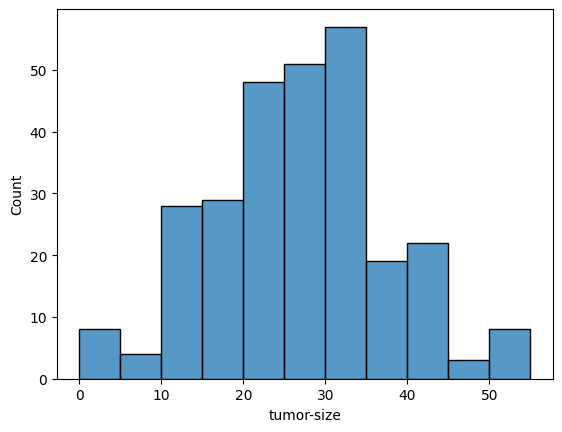

In [32]:
sns.histplot(data=bc['tumor-size'], bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55])

### Inv Nodes

Here there are several outliers, i.e. values more than 3 standard deviations from the mean. The same issue could crop up as with menopause. These only amount to 10 entries, so they too are culled from the set, out of caution.

/usr/local/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='inv-nodes', ylabel='Count'>

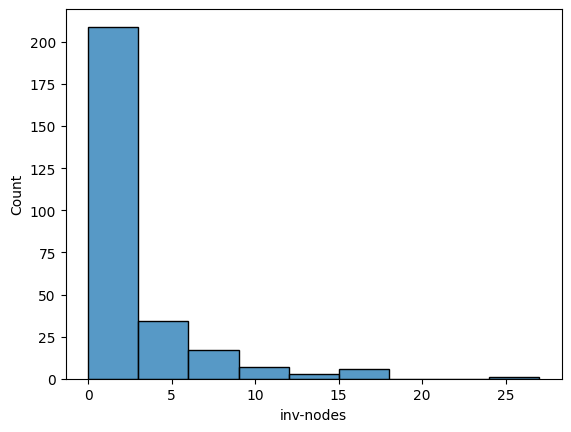

In [33]:
sns.histplot(data=bc['inv-nodes'], bins=[0, 3, 6, 9, 12, 15, 18, 21, 24, 27])

In [34]:
bc['inv-nodes'].mean() + 3 * bc['inv-nodes'].std()

12.744792283333641

In [35]:
len(bc[bc['inv-nodes'] > bc['inv-nodes'].mean() + 3 * bc['inv-nodes'].std()])

10

### Node Caps

Node caps are less common, but there are enough points to gain insight.

/usr/local/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<Axes: xlabel='node-caps', ylabel='count'>

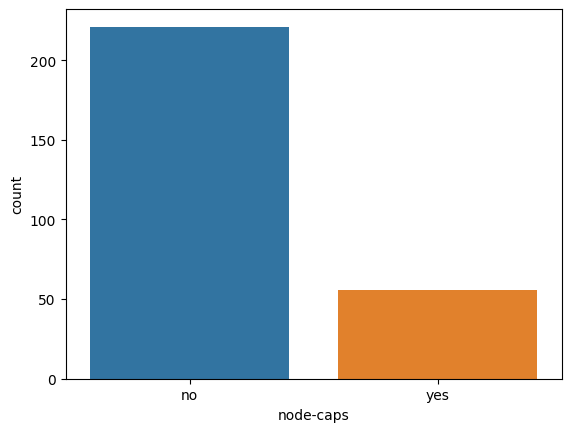

In [36]:
sns.countplot(x=bc['node-caps'])

### Deg Malig

All seems reasonable here.

/usr/local/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<Axes: xlabel='deg-malig', ylabel='count'>

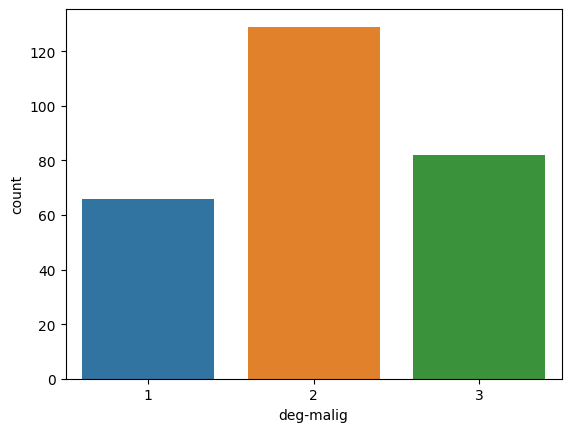

In [37]:
sns.countplot(x=bc['deg-malig'])

### Breast

As expected, the distribution of breast cancer is roughly symmetrical.

/usr/local/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<Axes: xlabel='breast', ylabel='count'>

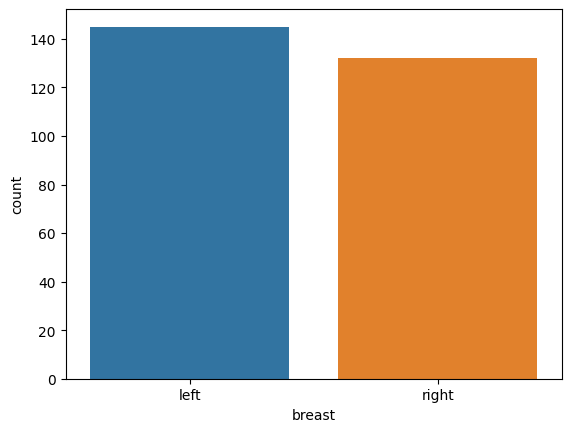

In [38]:
sns.countplot(x=bc['breast'])

### Breast Quad

Interestingly, there is a strong favoring of cases on the left side of the breast. Comparing this against the breast in which the tumor suggests that left breasts have more tumors in the lower quadrants, while right ones have more in the upper quadrants, revealing additional asymmetries, without an easily intuited explanation. This could be a product of inherent asymmetries in the human body, but it also signals the potential for bias in the data set. Not much can be done here. 

/usr/local/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<Axes: xlabel='breast-quad', ylabel='count'>

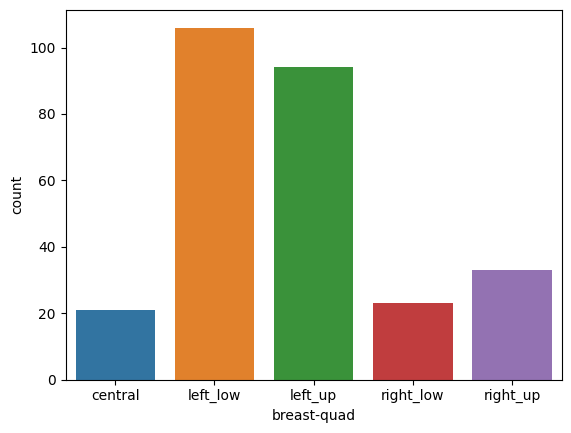

In [39]:
sns.countplot(x=bc['breast-quad'])

/usr/local/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<Axes: xlabel='breast-quad', ylabel='count'>

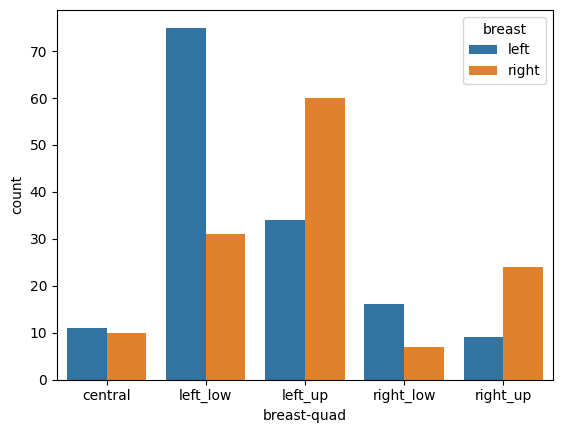

In [40]:
sns.countplot(x=bc['breast-quad'], hue=bc['breast'])

### Irradiat

Radiation treatment is less common, but there are enough points to gain insight.

/usr/local/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<Axes: xlabel='irradiat', ylabel='count'>

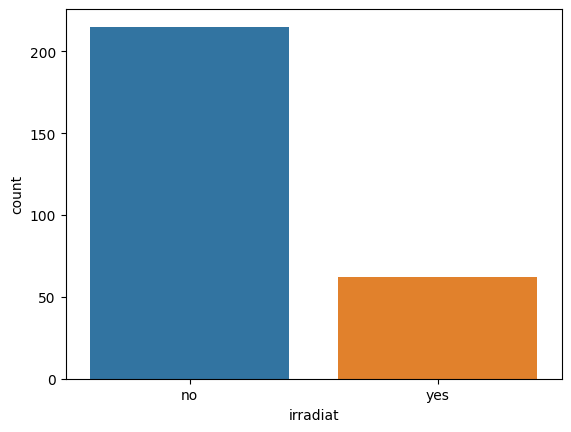

In [41]:
sns.countplot(x=bc['irradiat'])

## Drop Columns

All of the columns present seem appropriate for predicting breast cancer relapse. No columns are excluded from analysis.

## Drop Rows

The "lt40" category for menpause and outliers for inv nodes are culled from the data set, as discussed in the univariate analysis.

In [42]:
bc = bc[(bc['menopause'] != 'lt40') & (bc['inv-nodes'] <= (bc['inv-nodes'].mean() + 3 * bc['inv-nodes'].std()))]

In [43]:
bc['menopause'] = bc['menopause'].astype(str).astype('category')
bc['menopause'].unique()

['premeno', 'ge40']
Categories (2, object): ['ge40', 'premeno']

In [44]:
bc['inv-nodes'].unique()

array([ 1,  7, 10,  4])

## One-Hot Encoding

At this point, categorical variables will be converted to one-hot encoding, to make them useful for training machine learning models.

In [45]:
bc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 262 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   class        262 non-null    category
 1   age          262 non-null    int64   
 2   menopause    262 non-null    category
 3   tumor-size   262 non-null    float64 
 4   inv-nodes    262 non-null    int64   
 5   node-caps    262 non-null    category
 6   deg-malig    262 non-null    category
 7   breast       262 non-null    category
 8   breast-quad  262 non-null    category
 9   irradiat     262 non-null    category
dtypes: category(7), float64(1), int64(2)
memory usage: 10.9 KB


In [46]:
bc = pd.get_dummies(bc, columns=['class',
                                 'menopause',
                                 'node-caps',
                                 'deg-malig',
                                 'breast',
                                 'breast-quad',
                                 'irradiat'], drop_first=True)
bc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 262 entries, 0 to 285
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      262 non-null    int64  
 1   tumor-size               262 non-null    float64
 2   inv-nodes                262 non-null    int64  
 3   class_recurrence-events  262 non-null    bool   
 4   menopause_premeno        262 non-null    bool   
 5   node-caps_yes            262 non-null    bool   
 6   deg-malig_2              262 non-null    bool   
 7   deg-malig_3              262 non-null    bool   
 8   breast_right             262 non-null    bool   
 9   breast-quad_left_low     262 non-null    bool   
 10  breast-quad_left_up      262 non-null    bool   
 11  breast-quad_right_low    262 non-null    bool   
 12  breast-quad_right_up     262 non-null    bool   
 13  irradiat_yes             262 non-null    bool   
dtypes: bool(11), float64(1), int64(

In [47]:
bc.to_csv('bc_clean.csv')